In [1]:
import sys
sys.path.append('../../src')
sys.path.append('../../')
import json


config_file_path = "config.json"
with open(config_file_path, "r") as f:
    config_data = json.load(f)

config_data['PATH'] = '/home/viktor/Documents/idoven/idoven-challenge/data/physionet.org/files/ptb-xl/1.0.2/'

config_data

{'OUT': 'experiments/baseline/',
 'PATH': '/home/viktor/Documents/idoven/idoven-challenge/data/physionet.org/files/ptb-xl/1.0.2/',
 'TEST_FOLDS': [9, 10],
 'NUM_WORKERS_DATALOADER': 4,
 'SEED': 42,
 'BATCH_SIZE': 32,
 'BATCH_SIZE_EFFECTIVE': 32,
 'LMAX': 384,
 'LMAX_VALIDATION': 768,
 'AUGMENT': False,
 'TRAIN_ON_FFTS': False,
 'NFFT_COMPONENTS': 192,
 'USE_WEIGHTED_SAMPLER': False,
 'EPOCHS': 48,
 'LR_MAX': 0.0003,
 'MODEL': 'DeepHeartModel',
 'DIV': 25,
 'DIV_FINAL': 25,
 'MOMS': [0.95, 0.95, 0.95],
 'EMA': False,
 'MODEL_KWARGS': {'dim': 192,
  'dim_base': 128,
  'depth': 12,
  'head_size': 4,
  'drop_path': 0.2},
 'WEIGHTS': False,
 'LOSS_FUNC': 'binary_cross_entropy',
 'METRICS': ['multi_label_accuracy',
  'multilabel_hamming_loss',
  'macro_f1_score_multilabel']}

In [2]:
import torch
from models import DeepHeartModel
model = DeepHeartModel(**config_data["MODEL_KWARGS"]);

loaded_weights_path = 'models/model_2.pth'
loaded_weights = torch.load(loaded_weights_path, map_location=torch.device('cpu'))
model.load_state_dict(loaded_weights, strict=True)

<All keys matched successfully>

In [3]:
model = model.cuda()

In [4]:
import torch
from dataloaders import ECGDataset

ds_val = ECGDataset(
    path=config_data["PATH"],
    mode="val",
    L=config_data["LMAX_VALIDATION"],
    test_folds=config_data["TEST_FOLDS"],
)


[INFO] Loading data...
[INFO] Obtaining diagnostic_superclass for val mode ...
X.shape: (4306, 1000, 12), y.shape: (4306, 5)
X.min: -11.416, X.max: 12.966


In [5]:
len(ds_val)

4306

In [6]:
from tqdm import tqdm

# loop through ds_val

y_true_batch = []
y_pred_batch = []
model_preds = []


for i, out in enumerate(tqdm(ds_val, total=len(ds_val))):
    
    x, y = out[0], out[1]
    
    # send to device
    x['x'] = torch.unsqueeze(x['x'], 0).cuda()
    y['y'] = torch.unsqueeze(y['y'], 0).cuda()
    
    
    y_pred = torch.sigmoid(model(x))
    
    # convert to numpy
    y_pred_np = y_pred.cpu().detach().squeeze().numpy()
    
    # get y_true_np
    y_true_np = y['y'].cpu().detach().squeeze().numpy().astype(int)
    
    # append to batch
    y_true_batch.append(y_true_np)
    y_pred_batch.append(y_pred_np)
    
    
    # if i > 100:
    #     break

100%|██████████| 4306/4306 [00:54<00:00, 79.09it/s] 


In [7]:
y_true_batch_torch = {'y': torch.tensor(y_true_batch)}
y_pred_batch_torch = torch.tensor(y_pred_batch)

/tmp/ipykernel_435480/1140774863.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/torch/csrc/utils/tensor_new.cpp:245.)
  y_true_batch_torch = {'y': torch.tensor(y_true_batch)}


In [8]:
y_pred_batch_torch.shape, y_true_batch_torch['y'].shape

(torch.Size([4306, 5]), torch.Size([4306, 5]))

In [9]:
from metrics import multi_label_accuracy, multilabel_hamming_loss, macro_f1_score_multilabel, pr_auc_multilabel, auroc_multilabel

acc = multi_label_accuracy(y_pred_batch_torch, y_true_batch_torch, threshold=0.5, apply_sigmoid=False)
hamming_loss = multilabel_hamming_loss(y_pred_batch_torch, y_true_batch_torch, threshold=0.5, apply_sigmoid=False)
f1_score = macro_f1_score_multilabel(y_pred_batch_torch, y_true_batch_torch, threshold=0.5, apply_sigmoid=False)
pr_auc = pr_auc_multilabel(y_pred_batch_torch, y_true_batch_torch, apply_sigmoid=False)
auroc = auroc_multilabel(y_pred_batch_torch, y_true_batch_torch, apply_sigmoid=False)

acc, hamming_loss, f1_score, pr_auc, auroc

(tensor(0.8429),
 0.1571295866233163,
 0.562004053338806,
 0.6670289019383641,
 0.850787335011096)

In [10]:
y_true_batch_torch['y'].shape

torch.Size([4306, 5])

In [11]:
import numpy as np
from sklearn.metrics import f1_score

ths = np.arange(0.01, 1.0, 0.01)
accs = []
hamming_losses = []
f1_scores = []
pr_aucs = []
aurocs = []
per_class_f1_score = {}


# calculate per_class_f1_score
n_classes = y_pred_batch_torch.size(1)
    
    
for class_idx in range(n_classes):
    per_class_f1_score[class_idx] = []



for th in tqdm(ths):
    
    acc = multi_label_accuracy(y_pred_batch_torch, y_true_batch_torch, threshold=th, apply_sigmoid=False)
    hamming_loss = multilabel_hamming_loss(y_pred_batch_torch, y_true_batch_torch, threshold=th, apply_sigmoid=False)
    f1_score_val = macro_f1_score_multilabel(y_pred_batch_torch, y_true_batch_torch, threshold=th, apply_sigmoid=False)
    pr_auc = pr_auc_multilabel(y_pred_batch_torch, y_true_batch_torch,  apply_sigmoid=False)
    auroc = auroc_multilabel(y_pred_batch_torch, y_true_batch_torch, apply_sigmoid=False)
    
    
    
    
    for class_idx in range(n_classes):
        y_true = y_true_batch_torch['y'].cpu().numpy()[:, class_idx]
        y_pred = y_pred_batch_torch.cpu().numpy()[:, class_idx] > th
        
        per_class_f1_score[class_idx].append(f1_score(y_true, y_pred))


    accs.append(acc.item())
    hamming_losses.append(hamming_loss)
    f1_scores.append(f1_score_val)
    pr_aucs.append(pr_auc)
    aurocs.append(auroc)
    
    

100%|██████████| 99/99 [00:01<00:00, 81.92it/s]


Text(0.5, 0, 'Threshold')

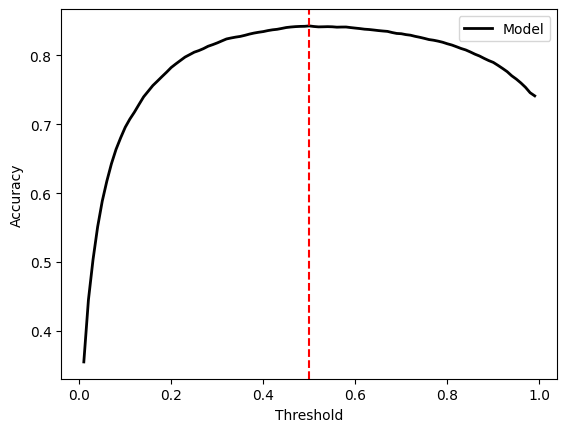

In [12]:
import matplotlib.pyplot as plt

plt.plot(ths, accs, color='black', lw=2, label='Model')
idx_max = np.argmax(accs)
# plot vertical line at max accuracy
plt.axvline(x=ths[idx_max], color='r', linestyle='--')




plt.legend()

plt.ylabel('Accuracy')
plt.xlabel('Threshold')
# plt.ylim(0.9, 0.92)

Text(0.5, 0, 'Threshold')

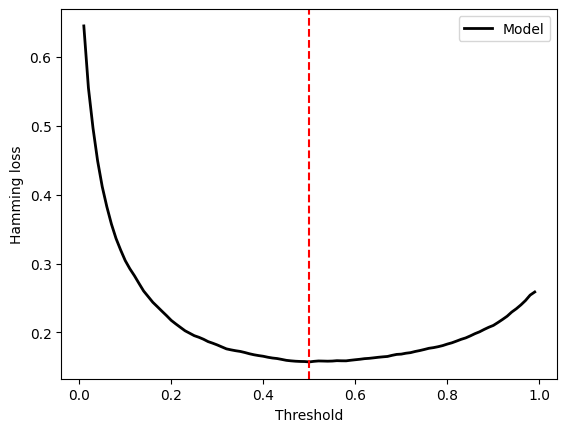

In [13]:
plt.plot(ths, hamming_losses, color='black', lw=2, label='Model')
idx_min = np.argmin(hamming_losses)
# plot vertical line at max accuracy
plt.axvline(x=ths[idx_min], color='r', linestyle='--')


plt.legend()

plt.ylabel('Hamming loss')
plt.xlabel('Threshold')
# plt.ylim(0.07, 0.1)


Text(0.5, 0, 'Threshold')

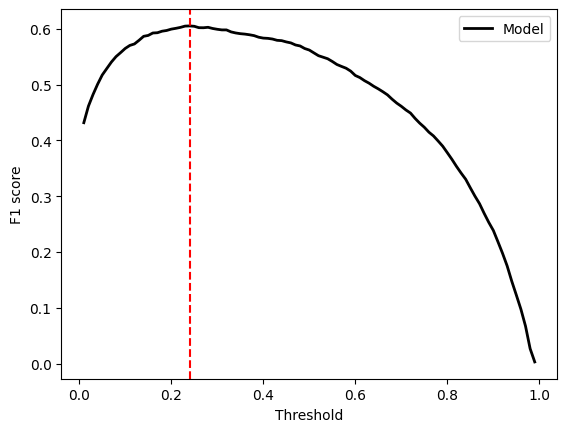

In [14]:
plt.plot(ths, f1_scores, color='black', lw=2, label='Model')
idx_max = np.argmax(f1_scores)
# plot vertical line at max accuracy
plt.axvline(x=ths[idx_max], color='r', linestyle='--')


plt.legend()

plt.ylabel('F1 score')
plt.xlabel('Threshold')
# plt.ylim(0.58, 0.68)

Text(0.5, 0, 'Threshold')

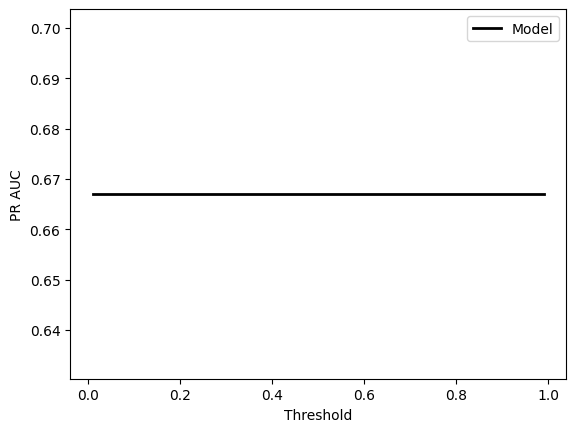

In [15]:
plt.plot(ths, pr_aucs, color='black', lw=2, label='Model')


plt.legend()

plt.ylabel('PR AUC')
plt.xlabel('Threshold')
# plt.ylim(0.58, 0.65)

Ensemble AUROC: 0.850787335011096


Text(0, 0.5, 'AUROC')

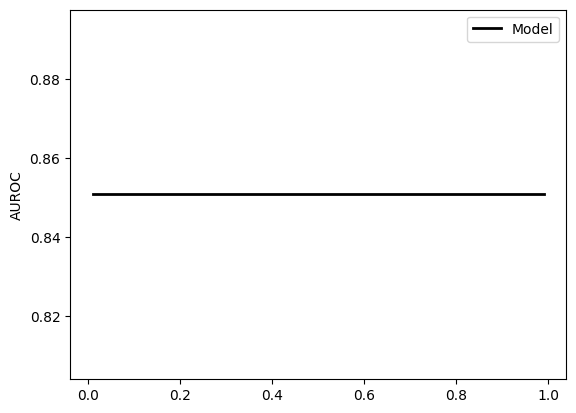

In [16]:
plt.plot(ths, aurocs, color='black', lw=2, label='Model')



plt.legend()

print(f'Ensemble AUROC: {aurocs[-1]}')


plt.ylabel('AUROC')
# plt.ylim(0.58, 0.65)

# Per class F1 score

Best th for class ['CD']: 0.31
Best th for class ['HYP']: 0.14
Best th for class ['MI']: 0.33
Best th for class ['NORM']: 0.45
Best th for class ['STTC']: 0.39


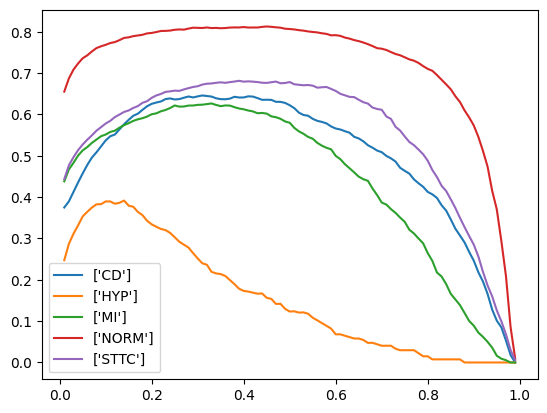

In [17]:
from dataloaders import decode_label

best_thresholds = []

for class_indx in range(5):
    class_indx_onehot = np.zeros(5)
    class_indx_onehot[class_indx] = 1
    class_decoded = decode_label(class_indx_onehot, ds_val.unique_superclasses)
    plt.plot(ths, per_class_f1_score[class_indx], label=class_decoded)
    
    # print best th per class
    best_th = ths[np.argmax(per_class_f1_score[class_indx])]
    print(f'Best th for class {class_decoded}: {best_th}')
    
    best_thresholds.append(best_th)
    
    
plt.legend()

# Confusion matrix

To be compared with 2202.00567 (https://arxiv.org/abs/2202.00567)


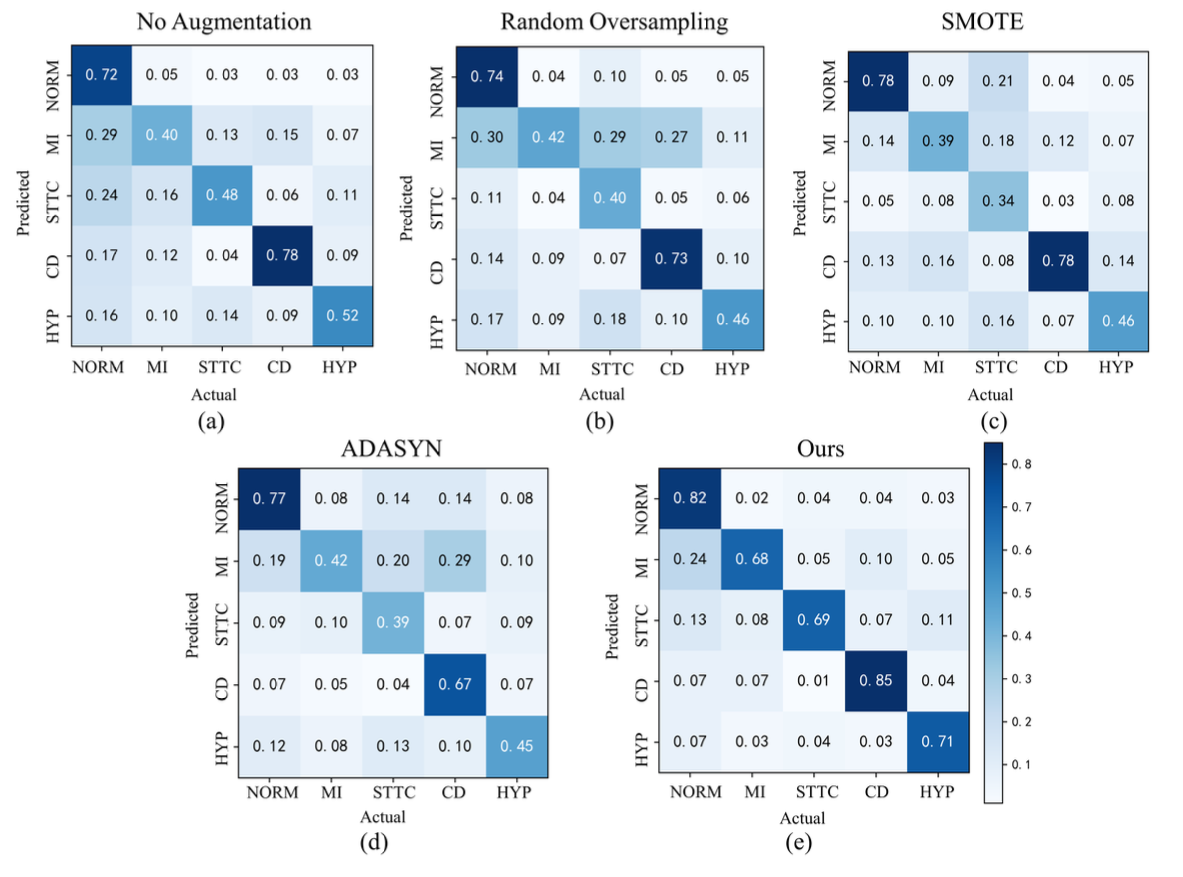

In [18]:
y_true_np = y_true_batch_torch['y'].cpu().numpy()
y_pred_np = y_pred_batch_torch.cpu().numpy()

y_true_np.shape, y_pred_np.shape # ((2183, 6), (2183, 6))

# Construct a confusion matrix for each class

((4306, 5), (4306, 5))

In [19]:
y_true_np = y_true_batch_torch['y'].cpu().numpy()
y_pred_np = y_pred_batch_torch.cpu().numpy()

y_true_np.shape, y_pred_np.shape

((4306, 5), (4306, 5))

## Best per-class threshold co-occurence matrices

/tmp/ipykernel_435480/1184329961.py:18: RuntimeWarning: invalid value encountered in divide
  co_occurrence_matrix_normalized = co_occurrence_matrix / column_sums[np.newaxis, :]


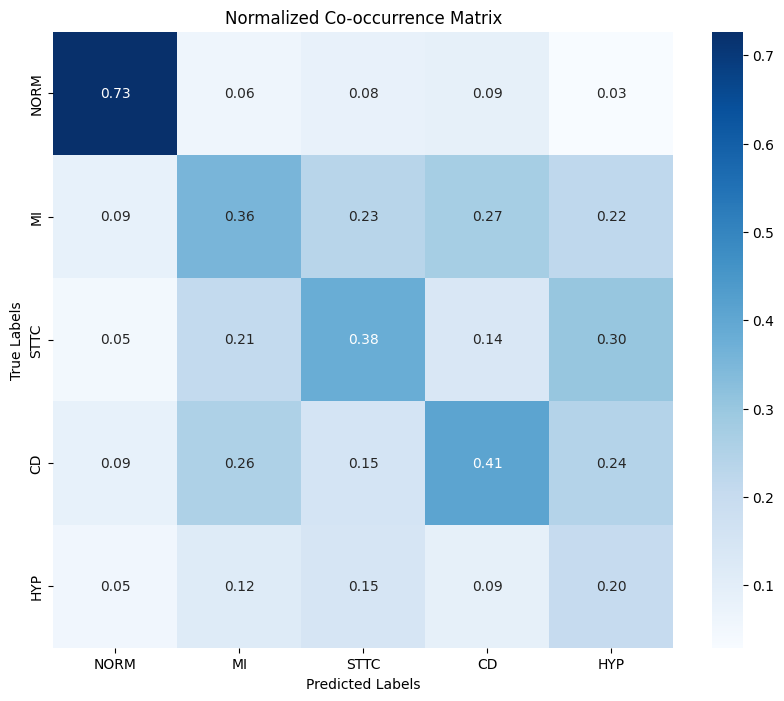

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


co_occurrence_matrix = np.zeros((6, 6))

for i in range(5):
    
    for j in range(5):
        
        co_occurrence_matrix[i, j] = np.sum(np.logical_and(y_true_np[:, i] == 1, y_pred_np[:, j] > best_thresholds[j]))
        


# Normalize columns
column_sums = co_occurrence_matrix.sum(axis=0)
co_occurrence_matrix_normalized = co_occurrence_matrix / column_sums[np.newaxis, :]

# Adjust row and column order
desired_order = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
current_order = ds_val.unique_superclasses

reordered_matrix = np.zeros((5, 5))
for i, row_class in enumerate(desired_order):
    for j, col_class in enumerate(desired_order):
        row_index_in_current_order = current_order.index(row_class)
        col_index_in_current_order = current_order.index(col_class)
        reordered_matrix[i, j] = co_occurrence_matrix_normalized[row_index_in_current_order, col_index_in_current_order]

# Visualizing
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Co-occurrence Matrix")
plt.show()


##  threshold=0.5 co-occurence matrices

/tmp/ipykernel_435480/2510979424.py:18: RuntimeWarning: invalid value encountered in divide
  co_occurrence_matrix_normalized = co_occurrence_matrix / column_sums[np.newaxis, :]


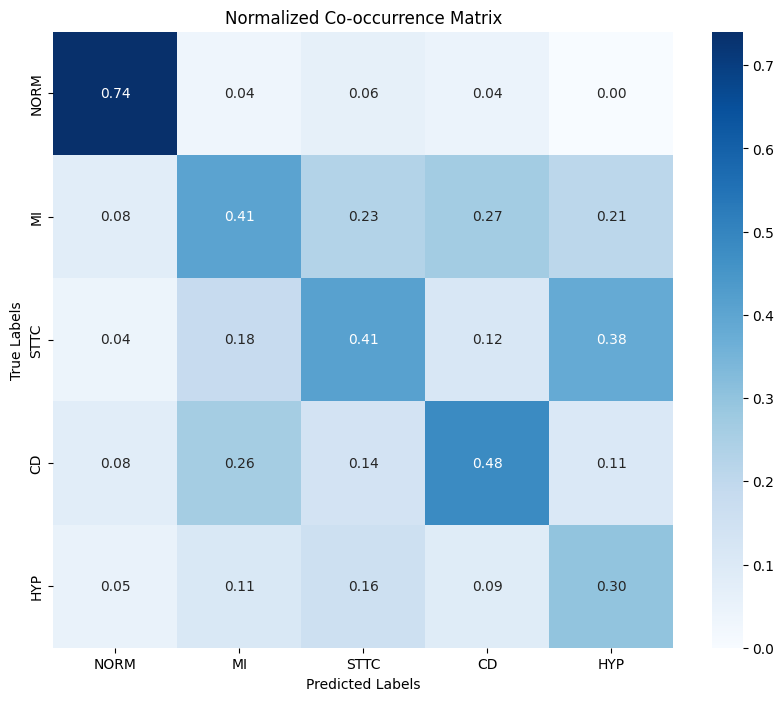

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


co_occurrence_matrix = np.zeros((6, 6))

for i in range(5):
    
    for j in range(5):
        
        co_occurrence_matrix[i, j] = np.sum(np.logical_and(y_true_np[:, i] == 1, y_pred_np[:, j] > 0.5))
        


# Normalize columns
column_sums = co_occurrence_matrix.sum(axis=0)
co_occurrence_matrix_normalized = co_occurrence_matrix / column_sums[np.newaxis, :]

# Adjust row and column order
desired_order = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
current_order = ds_val.unique_superclasses

reordered_matrix = np.zeros((5, 5))
for i, row_class in enumerate(desired_order):
    for j, col_class in enumerate(desired_order):
        row_index_in_current_order = current_order.index(row_class)
        col_index_in_current_order = current_order.index(col_class)
        reordered_matrix[i, j] = co_occurrence_matrix_normalized[row_index_in_current_order, col_index_in_current_order]

# Visualizing
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Co-occurrence Matrix")
plt.show()


## Best per-class threshold confusion matrices

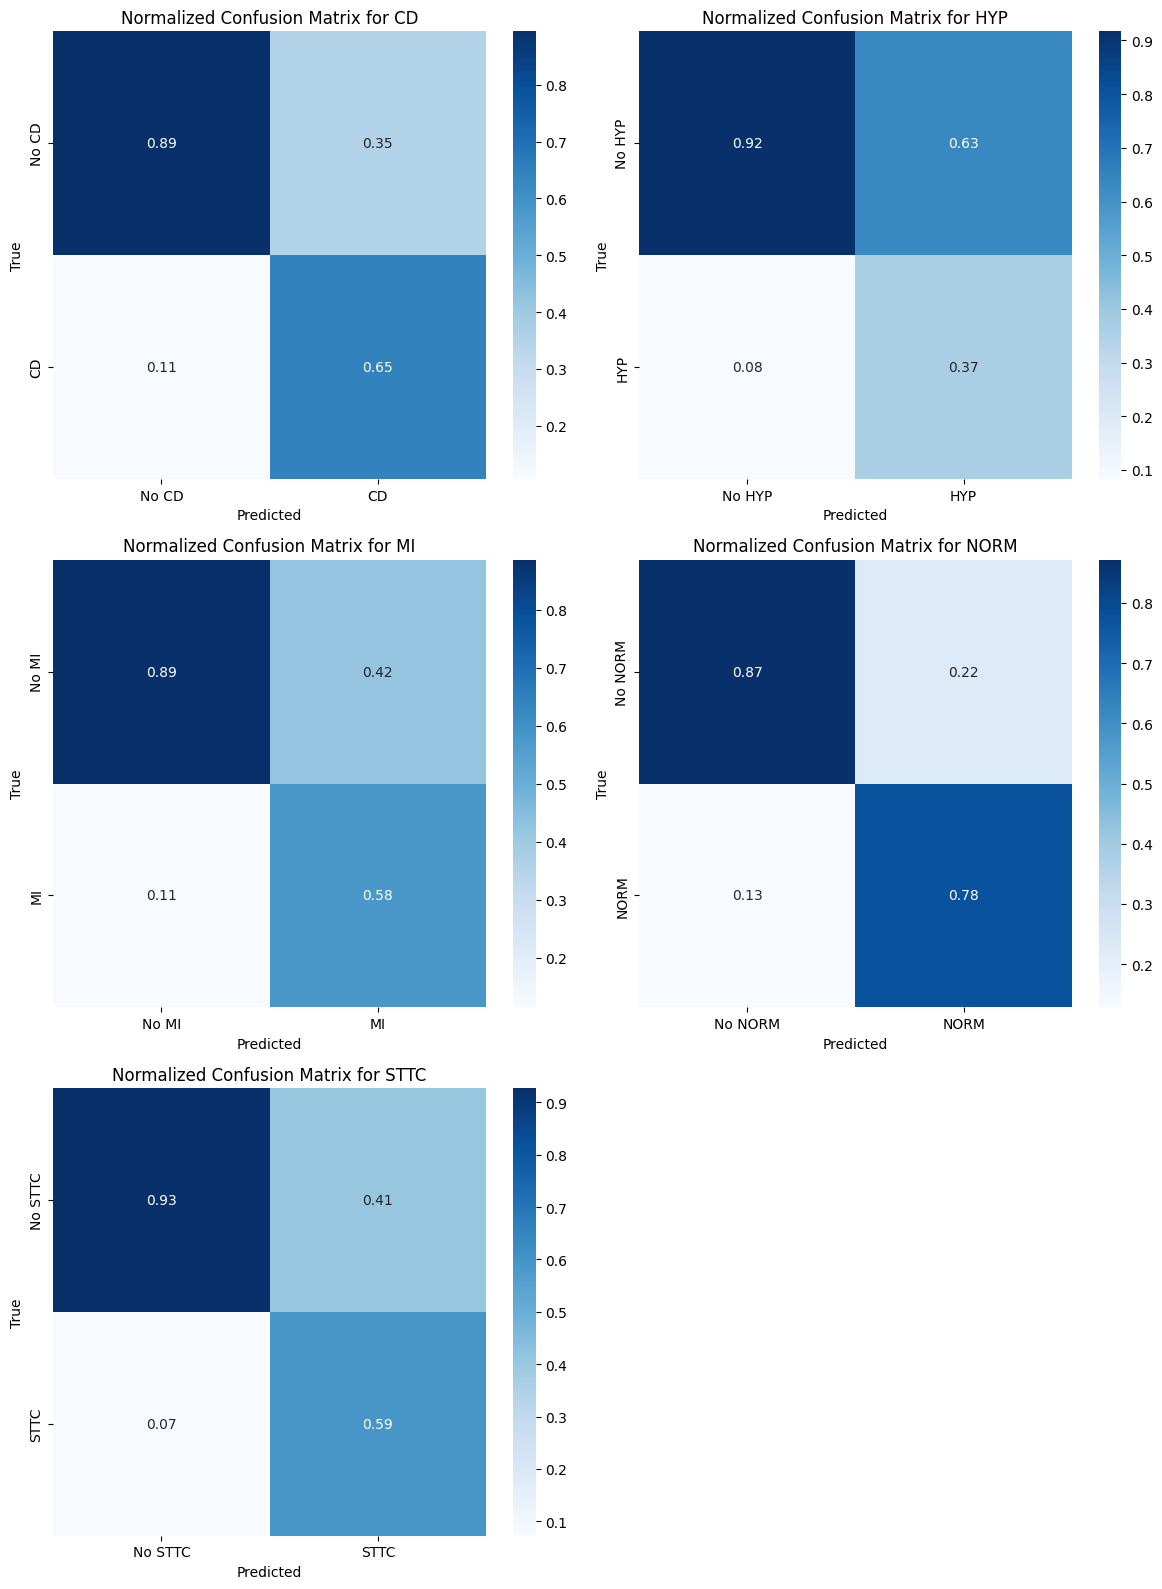

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_true_np = y_true_batch_torch['y'].cpu().numpy()
y_pred_np = y_pred_batch_torch.cpu().numpy()

# Assuming a threshold of 0.5 to classify predictions
y_pred_bin = (y_pred_np > 0.5).astype(int)

n_classes = y_true_np.shape[1]
all_confusion_matrices = []

for i in range(n_classes):
    class_true = y_true_np[:, i]
    # class_pred = y_pred_bin[:, i]
    
    class_pred = (y_pred_np > best_thresholds[i]).astype(int)[:, i]
    
    cm = confusion_matrix(class_true, class_pred)
    all_confusion_matrices.append(cm)
    
    
    normalized_confusion_matrices = []

for matrix in all_confusion_matrices:
    # Normalize each row by its sum
    # normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    # normalized_confusion_matrices.append(normalized_matrix)
    
    # Normalize each column by its sum
    normalized_matrix = matrix.astype('float') / matrix.sum(axis=0)[np.newaxis, :]
    normalized_confusion_matrices.append(normalized_matrix)



import matplotlib.pyplot as plt
import seaborn as sns

class_names = ds_val.unique_superclasses

plt.figure(figsize=(12, 16))
for idx, (confusion_mtx, class_name) in enumerate(zip(normalized_confusion_matrices, class_names)):
    plt.subplot(3, 2, idx + 1)  # 3x2 grid
    sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap="Blues", 
                xticklabels=['No ' + class_name, class_name], 
                yticklabels=['No ' + class_name, class_name])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Normalized Confusion Matrix for {class_name}')

plt.tight_layout()  # to ensure proper spacing between subplots
plt.show()


## threshold=0.5 confusion matrices

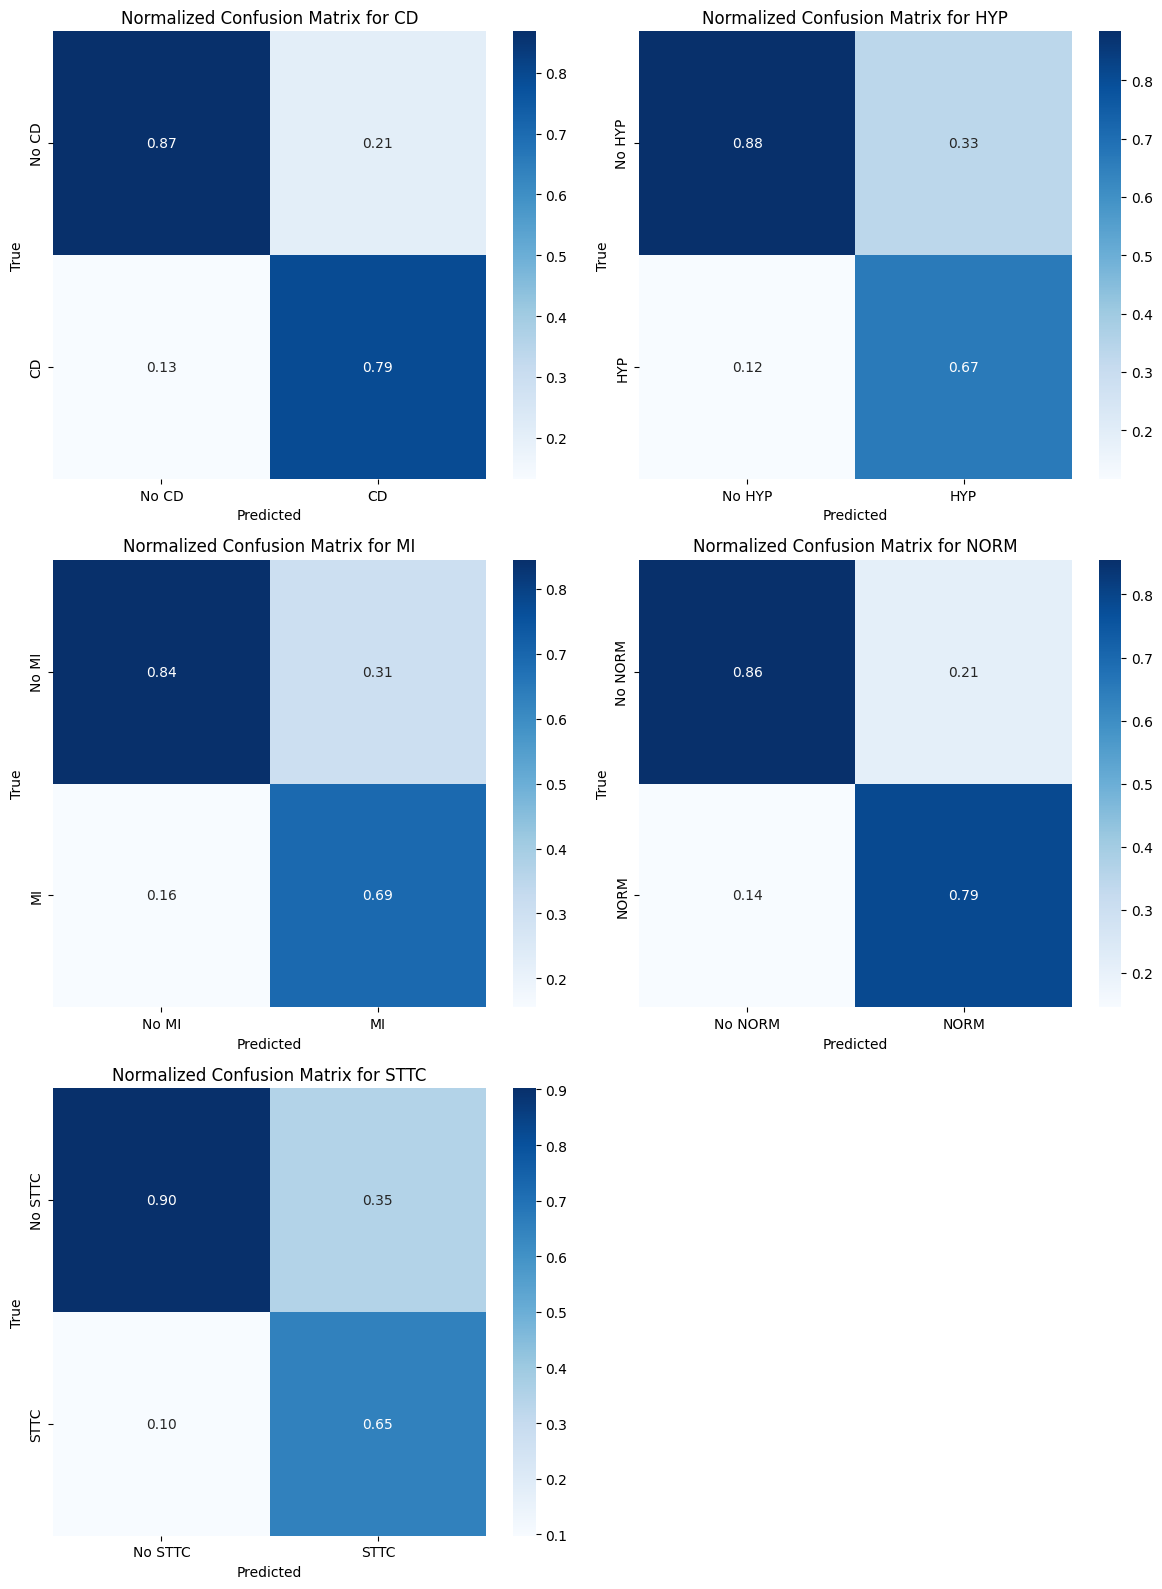

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_true_np = y_true_batch_torch['y'].cpu().numpy()
y_pred_np = y_pred_batch_torch.cpu().numpy()

# Assuming a threshold of 0.5 to classify predictions
y_pred_bin = (y_pred_np > 0.5).astype(int)

n_classes = y_true_np.shape[1]
all_confusion_matrices = []

for i in range(n_classes):
    class_true = y_true_np[:, i]
    # class_pred = y_pred_bin[:, i]
    
    class_pred = (y_pred_np > 0.5).astype(int)[:, i]
    
    cm = confusion_matrix(class_true, class_pred)
    all_confusion_matrices.append(cm)
    
    
    normalized_confusion_matrices = []

for matrix in all_confusion_matrices:
    # Normalize each row by its sum
    # normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    # normalized_confusion_matrices.append(normalized_matrix)
    
    # Normalize each column by its sum
    normalized_matrix = matrix.astype('float') / matrix.sum(axis=0)[np.newaxis, :]
    normalized_confusion_matrices.append(normalized_matrix)



import matplotlib.pyplot as plt
import seaborn as sns

class_names = ds_val.unique_superclasses

plt.figure(figsize=(12, 16))
for idx, (confusion_mtx, class_name) in enumerate(zip(normalized_confusion_matrices, class_names)):
    plt.subplot(3, 2, idx + 1)  # 3x2 grid
    sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap="Blues", 
                xticklabels=['No ' + class_name, class_name], 
                yticklabels=['No ' + class_name, class_name])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Normalized Confusion Matrix for {class_name}')

plt.tight_layout()  # to ensure proper spacing between subplots
plt.show()


Wow :/ 

The model is really having trouble with classes that occur rarely. Maybe I should implement WeightedRandomSampler.